# Solving non-linear diffusion equation using ODE-ELM

In [2]:
# Imports
import sys
sys.path.append('../../')
sys.path.append('../../src')
from sklearn.preprocessing import MinMaxScaler
from swimpde import Domain
from swimpde import BasicAnsatz
from swimpde import Nonlinear_Diffusion_Solver
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm
np.random.seed(2)
import time
cmap = cm.jet
from examples import utils

### Load point cloud data

In [3]:
# Read and scale data
scaler = MinMaxScaler(feature_range=(0.65, 0.9))

# Load and preprocess training data
data_boundary = np.load('../../data/nature_inspired_dataset/nature_inspired_boundary_1000.npy')
data_interior = np.load('../../data/nature_inspired_dataset/nature_inspired_interior_1000.npy')
data_full = np.vstack((data_boundary, data_interior))
data_new = scaler.fit_transform(data_full) 
data_boundary = data_new[:np.shape(data_boundary)[0], :]
data_interior = data_new[np.shape(data_boundary)[0]::, :]

# Load and preprocess test data
data_eval = np.load('../../data/nature_inspired_dataset/nature_inspired_eval.npy')
x_eval = scaler.fit_transform(data_eval)

### Problem setup

In [4]:
import math
# initial condition
def u0(x):
    return np.sin(np.pi * x[:, 0]) * x[:, 1]**-3  

# forcing
def forcing(x, t):    
    return np.exp(-t) * np.sin(np.pi * x[:, 0]) * x[:, 1]**(-3) * (-1. - (-1) * np.exp(-t) * x[:, 1]**(-5) * np.sin(np.pi*x[:, 0]) * (-12 + np.pi**2 * x[:, 1]**2) )

# boundary condition
boundary_condition = "dirichlet"

# Analytical solution
def analytical_sol(x, t):
    return np.exp(-t) * np.sin(np.pi * x[:, 0]) * x[:, 1]**-3  
    
# Test data
t_eval = np.linspace(0, 1, 100).reshape(-1, 1, 1) # time domain
x_train = data_interior # space domain
u_true =  analytical_sol(x_eval, t_eval)
u_true = np.reshape(u_true, (np.shape(u_true)[0], np.shape(u_true)[2]))

### Visualize ground truth

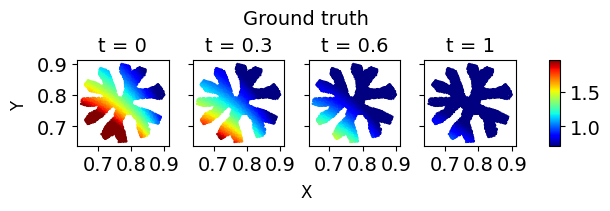

In [5]:
# Visualize the true solution
timesteps = [0, 30, 60, 99]
utils.plot(x=x_eval, u=u_true, timesteps=timesteps, 
           title='Ground truth', cmap_offset=0,
           savefig=True,figname='ground_truth.png')

### Fit and evaluate ELM-ODE for good hyper-parameters 

In [6]:
seeds = [1, 2, 3]
experiments = []

def set_hyperparams(case:str):
    if case == 'fast':
        width = 300 # Width
        reg_const = 1e-10 # Regularization constant
        svd_cutoff = 1e-10
    else:
        width = 200 # Width
        reg_const = 1e-15 # Regularization constant
        svd_cutoff = 1e-15
    return width, reg_const, svd_cutoff

width, reg_const, svd_cutoff = set_hyperparams('fast')
rtol = 1e-6
atol = 1e-6
# Loop over different seeds
rmse_elm = np.ones((len(seeds), ))
rel_err_elm = np.ones((len(seeds), ))
time_elm = np.ones((len(seeds), ))
j = 0
info = []
for seed in seeds:
    # Parameter sampler for ELM: Sample weights from a normal distribution and biases uniformly from [-4, 4]
    def sample_parameters_randomly(x, _, rng):
        weights = rng.normal(loc=0, scale=1, size=(x.shape[1], width))
        biases = rng.uniform(low=-4, high=4, size=(1, width)) # low=-np.pi, high=np.pi,  2 * np.pi
        idx0 = None
        idx1 = None
        return weights, biases, idx0, idx1

    ansatz_elm = BasicAnsatz(
        n_neurons=width,
        activation="tanh",
        random_state=seed,
        regularization_scale=reg_const,
        parameter_sampler = sample_parameters_randomly
    )
    
    # Interior points
    normal_vectors = data_boundary.copy()
    # Domain
    domain = Domain(
        interior_points=data_interior,
        boundary_points=data_boundary,
        normal_vectors=normal_vectors
    )
    nonlinear_diffusion_solver_elm = Nonlinear_Diffusion_Solver(
        domain=domain, 
        ansatz=ansatz_elm,
        u0=u0,
        boundary_condition=boundary_condition,
        forcing=forcing,
        regularization_scale=reg_const,
        scale_boundary_correction=1.,
        boundary_condition_true=analytical_sol
    )
    # Compute weights and biases of the SWIM network
    time_blocks = 1
    ic_eval = u0(domain.interior_points)
    t_elm_start = time.time()
    sol_elm, solver_status_elm = nonlinear_diffusion_solver_elm.fit(t_span=[0, np.max(t_eval)], 
                                                                       rtol = rtol, atol = atol, svd_cutoff= svd_cutoff,
                                                                        outer_basis=False,
                                                                        init_cond=ic_eval);
    t_elm_stop = time.time()
    time_elm[j] = t_elm_stop - t_elm_start

    # Evaluate on test data
    u_elm_test = nonlinear_diffusion_solver_elm.evaluate(x_eval=x_eval, t_eval = t_eval).T #, solver_status=solver_status
                
    # Compute metrics
    rmse_elm[j] = np.sqrt(mean_squared_error(u_true, u_elm_test))
    rel_err_elm[j] = rmse_elm[j]/np.sqrt(mean_squared_error(u_true, np.zeros_like(u_true)))
    info.append(time_elm[j])
    info.append(rmse_elm[j])
    info.append(rel_err_elm[j])
    print('time=', time_elm[j], 'rmse_elm=', rmse_elm[j], 'rel_err_elm=',rel_err_elm[j])
    j += 1

print('elm-ode time = ', np.mean(time_elm))
print('rmse elm-ode = ',np.mean(rmse_elm), '+-', np.std(rmse_elm))
print('rel l-2 error elm-ode = ',np.mean(rel_err_elm), '+-', np.std(rel_err_elm))
experiments.append(info)


time= 7.6800696849823 rmse_elm= 0.009659942956645576 rel_err_elm= 0.00986846563449254
time= 14.6868257522583 rmse_elm= 0.007114441694169829 rel_err_elm= 0.007268016351920141
time= 10.870229482650757 rmse_elm= 0.005254592481273539 rel_err_elm= 0.0053680198275950705
elm-ode time =  11.079041639963785
rmse elm-ode =  0.007342992377362981 +- 0.0018057232648454565
rel l-2 error elm-ode =  0.007501500604669251 +- 0.0018447021959143092


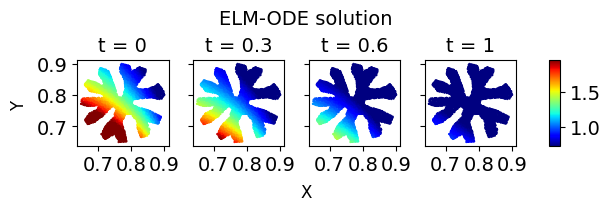

In [7]:
# Plot the ELM-ODE solution
utils.plot(x=x_eval, u=u_elm_test, timesteps=timesteps, title='ELM-ODE solution',cmap_offset=0.)

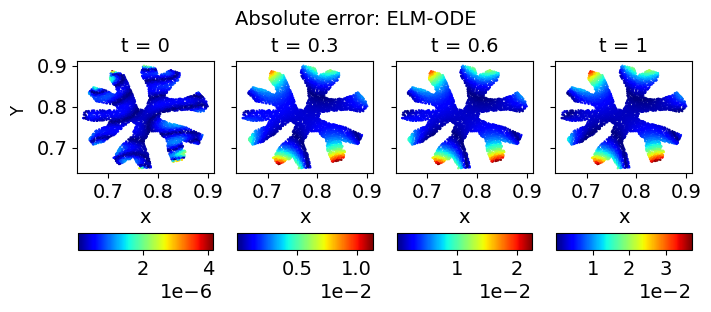

In [8]:
# Plot the absolute error with ELM-ODE
utils.plot_error(x=x_eval, u_true=u_true, u_nn=u_elm_test, timesteps=timesteps, 
           figsize=(7,3), fontsize=14, 
           title='Absolute error: ELM-ODE',savefig=True, 
           figname='elm_ode_error.png')